# Results and validation


In this section the some results are shown by using the implemented class. The forward integration will be done by using the library function `scipy.integrate.solve_ivp()`, which will allow us to use all kinds of advanced integrators.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib

import time
# import pandas as pd

import one_d_problem_physics as opp


Setup matplotlib parameters for appropriately sized plots.

In [2]:
plt.rcParams["figure.figsize"] = (8,6)
font = {'size'   : 14}
matplotlib.rc('font', **font)

## Validation I: imbibition experiment
In an imbibition experiment a specimen is brought into contact with water on one side. The capillary forces will make the specimen transport water into its pores. This will be modeled by creating a constantly moisture saturated material cell on the one side of the specimen. The other side is assumed to be air- and water-tight.

### Problem setup

In [3]:
val_problem = opp.one_d_problem(res=40, sim_time=100, material='AAC_A4_mod', init_w=0, length=.1, w_west=1, w_east=0)
val_problem.fluid_flow_west = True
val_problem.fluid_flow_east = False
val_problem.vapour_flow_west = False
val_problem.vapour_flow_east = False

val_problem.liquid_conduction = True
val_problem.vapour_diffusion = True

t0 = 0  # Start time in hours
tf = val_problem.sim_time  # End time in hours
t_eval = np.linspace(t0, tf, 100)
w0 = val_problem.w[:]

### Solving

In [4]:
print('Calling scipy.integrate.slove_ivp() ...')
start_time = time.time()
val_sol = solve_ivp(val_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method='Radau',
                vectorized=False, dense_output=False, atol=1e-7, rtol=1e-5)
print(f'time elapsed: {(time.time() - start_time):.3f} s')


Calling scipy.integrate.slove_ivp() ...


G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:22: RuntimeWarning: overflow encountered in exp
  rh = np.exp(-p_suc / (rho_w * Rv * T_ref))
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:250: RuntimeWarning: invalid value encountered in multiply
  dwdt[-2] += self.delta_p / self.dx**2 * (p_vap[-1] - p_vap[-2]) * self.vapour_flow_east * self.vapour_diffusion


time elapsed: 3.365 s


### Plotting

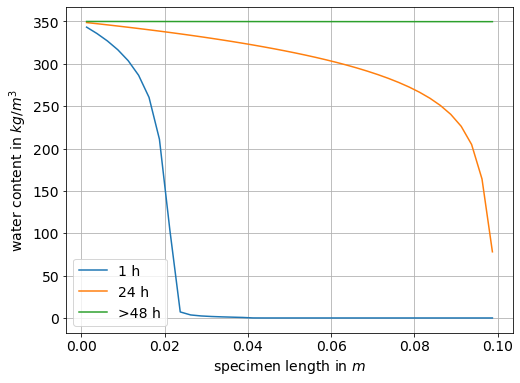

In [5]:
plt.plot(val_problem.x, val_sol.y[1:-1,1], label="1 h")
plt.plot(val_problem.x, val_sol.y[1:-1,24], label="24 h")
plt.plot(val_problem.x, val_sol.y[1:-1,48], label=">48 h")
plt.legend()
plt.grid()
plt.xlabel('specimen length in $m$')
plt.ylabel('water content in $kg/m^3$')
plt.show()

Comparing this to the literature, we see that the results are in accordance with {cite}`A4`:
![title](img/A4_imbibition.jpg)

## Validation II: drying experiment
In the drying experiment the specimen starts with a certain moisture and is exposed to a room with a certain temperature and moisture (here we use $T=23°C$ and $\varphi=50%$). Liquid water will not be allowed to flow to the room, but vapor can diffuse. This situation will be modeled by creating a material cell, that has vapor pressure of that air. The diffusion coefficient for passing into the material cell is not quite the same as it would be for passing from the surface of the specimen into the room. This difference will be neglected here. 

The other side will be assumed to be air- and water-tight.

### Problem setup

In [6]:
# drying...
# ------------

# calculate P_suc and w for 23°C, 50%rH:
P_suc_west = opp.p_suc_kelvin_calc(0.5)


vval_problem = opp.one_d_problem(res=80, sim_time=100, material='AAC_A4_mod', init_w=0, length=.1, w_west=0, w_east=0)
w_sat = vval_problem.free_saturation
w_west = vval_problem.w_calc(P_suc_west) / w_sat
val_problem = opp.one_d_problem(res=80, sim_time=1000, material='AAC_A4_mod_dry', init_w=310/w_sat, length=.1, w_west=w_west, w_east=0)
# val_problem = opp.one_d_problem(res=30, sim_time=1000, material='AAC_A4_mod', init_w=310/350, length=.1, w_west=0, w_east=0)


val_problem.fluid_flow_west = False
val_problem.fluid_flow_east = False
val_problem.vapour_flow_west = True
val_problem.vapour_flow_east = False

val_problem.liquid_conduction = True
val_problem.vapour_diffusion = True

t0 = 0  # Start time in hours
tf = val_problem.sim_time  # End time in hours
t_eval = np.linspace(t0, tf, 1000)
w0 = val_problem.w[:]


In [7]:
print('Calling scipy.integrate.slove_ivp() ...')
start_time = time.time()
val_sol = solve_ivp(val_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method='Radau',
                vectorized=False, dense_output=False, atol=1e-7, rtol=1e-5)
print(f'time elapsed: {(time.time() - start_time):.3f} s')

Calling scipy.integrate.slove_ivp() ...
time elapsed: 1.555 s


### Plotting

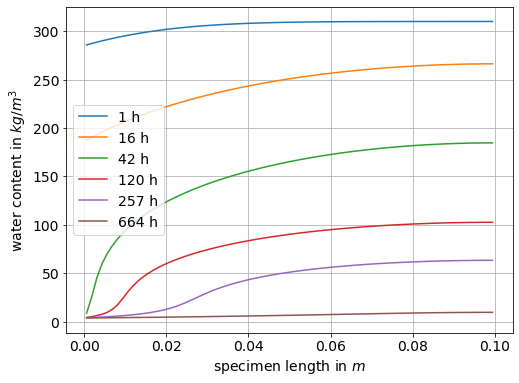

In [8]:
plt.plot(val_problem.x, val_sol.y[1:-1, 1], label="1 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 16], label="16 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 42], label="42 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 120], label="120 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 257], label="257 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 664], label="664 h")
plt.legend()
plt.grid()
plt.xlabel('specimen length in $m$')
plt.ylabel('water content in $kg/m^3$')
plt.show()

Comparing this to the literature, we see that the results are in accordance with {cite}`A4`, if the starting point is considered to be the $80h$ mark in the figure below. The process before $80h$ is determined by a model describing porous material, that is moist beyond capillary saturation, which is out of scope of this project:
![title](img/A4_drying.jpg)